In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Embedding, Conv1D, BatchNormalization, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn import metrics

from dataUtils import DataUtils
from model_utils import ModelUtils

C:\Users\Yang\.conda\envs\test_speedcom\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
dset = DataUtils.readData('cleaned_data_emission.tsv', sep='\t')

   #      Name  Epsilon      Solvent  Quantum Yield    Solvent.1  \
0  1   Benzene      210  cyclohexane          0.053       hexane   
1  2   Toluene     2860  cyclohexane          0.170  cyclohexane   
2  3  o-Xylene      254  cyclohexane          0.170       hexane   
3  4  m-Xylene      284  cyclohexane          0.130       hexane   
4  5  p-Xylene      770  cyclohexane          0.220       hexane   

                            File                         File.1  Absorption  \
0    A01_71-43-2_Benzene.abs.txt    A01_71-43-2_Benzene.ems.txt      254.75   
1   A02_108-88-3_Toluene.abs.txt   A02_108-88-3_Toluene.ems.txt      261.75   
2   A03_95-47-6_o-Xylene.abs.txt   A03_95-47-6_o-Xylene.ems.txt      263.00   
3  A04_108-38-3_m-Xylene.abs.txt  A04_108-38-3_m-Xylene.ems.txt      265.00   
4  A05_106-42-3_p-Xylene.abs.txt  A05_106-42-3_p-Xylene.ems.txt      275.00   

            SMILES  Emission  
0      C1=CC=CC=C1     287.0  
1     CC1=CC=CC=C1     289.5  
2    CC1=CC=CC=C1C     

In [3]:
X, y = DataUtils.get_xy(dset, 9, 8)

In [4]:
word_map = DataUtils.get_wordmap(x_smiles=X)

#### Set uniform length

In [5]:
uniform_length = DataUtils.get_max_len(X) + 5

In [6]:
X_numeric = DataUtils.numeric_encoding(x_list=X, word_map=word_map, uniform_length=uniform_length)

#### Save out wordmap as json file

In [8]:
DataUtils.save_wordmap_json(word_map, 'smiles_wordmap.json')

In [7]:
X_train, X_test, y_train, y_test = DataUtils.splitData(x=X_numeric, y=y, ratio=0.2)
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(232, 279)
(59, 279)
(232, 1)
(59, 1)


In [12]:
model = Sequential()
model.add(Embedding(len(word_map), 50, input_length=279))
model.add(BatchNormalization())
model.add(Conv1D(192,10,activation='relu'))
model.add(Dropout(0.4))
model.add(Conv1D(192,5,activation='relu'))
model.add(Conv1D(192,3,activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 279, 50)           2100      
_________________________________________________________________
batch_normalization_3 (Batch (None, 279, 50)           200       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 270, 192)          96192     
_________________________________________________________________
dropout_3 (Dropout)          (None, 270, 192)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 266, 192)          184512    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 264, 192)          110784    
_________________________________________________________________
flatten_3 (Flatten)          (None, 50688)             0         
__________

In [9]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-15, verbose=1, mode='auto',cooldown=0),
    ModelCheckpoint(filepath="weights.best.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')    
]

In [14]:
optimizer = Adam(lr=0.00025)
lr_metric = get_lr_metric(optimizer)
model.compile(loss="mse", optimizer=optimizer, metrics=[coeff_determination, lr_metric])

In [15]:
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=150, validation_data=(X_test,y_test))

Instructions for updating:
Use tf.cast instead.
Train on 232 samples, validate on 59 samples
Epoch 1/150
232/232 [==============================] - 5s 21ms/step - loss: 156550.3605 - coeff_determination: -6.7091 - lr: 2.5000e-04 - val_loss: 157771.3281 - val_coeff_determination: -6.3411 - val_lr: 2.5000e-04
Epoch 2/150
232/232 [==============================] - 3s 13ms/step - loss: 147630.5463 - coeff_determination: -6.2985 - lr: 2.5000e-04 - val_loss: 142741.0000 - val_coeff_determination: -5.6417 - val_lr: 2.5000e-04
Epoch 3/150
232/232 [==============================] - 3s 13ms/step - loss: 128511.2656 - coeff_determination: -5.3035 - lr: 2.5000e-04 - val_loss: 111250.1875 - val_coeff_determination: -4.1765 - val_lr: 2.5000e-04
Epoch 4/150
232/232 [==============================] - 3s 13ms/step - loss: 93211.4798 - coeff_determination: -3.5616 - lr: 2.5000e-04 - val_loss: 61335.8867 - val_coeff_determination: -1.8540 - val_lr: 2.5000e-04
Epoch 5/150
232/232 [========================

Epoch 38/150
232/232 [==============================] - 3s 14ms/step - loss: 11635.2747 - coeff_determination: 0.4288 - lr: 2.5000e-04 - val_loss: 12804.8047 - val_coeff_determination: 0.4042 - val_lr: 2.5000e-04
Epoch 39/150
232/232 [==============================] - 3s 14ms/step - loss: 12691.3335 - coeff_determination: 0.3771 - lr: 2.5000e-04 - val_loss: 12182.9121 - val_coeff_determination: 0.4331 - val_lr: 2.5000e-04
Epoch 40/150
232/232 [==============================] - 3s 14ms/step - loss: 12426.5866 - coeff_determination: 0.3860 - lr: 2.5000e-04 - val_loss: 11850.7354 - val_coeff_determination: 0.4486 - val_lr: 2.5000e-04
Epoch 41/150
232/232 [==============================] - 3s 14ms/step - loss: 12330.9471 - coeff_determination: 0.3806 - lr: 2.5000e-04 - val_loss: 11874.1221 - val_coeff_determination: 0.4475 - val_lr: 2.5000e-04
Epoch 42/150
232/232 [==============================] - 3s 14ms/step - loss: 11101.6004 - coeff_determination: 0.4511 - lr: 2.5000e-04 - val_loss: 1

Epoch 115/150
232/232 [==============================] - 3s 14ms/step - loss: 7042.8923 - coeff_determination: 0.6548 - lr: 2.5000e-04 - val_loss: 8198.0596 - val_coeff_determination: 0.6185 - val_lr: 2.5000e-04
Epoch 116/150
232/232 [==============================] - 4s 15ms/step - loss: 7750.1962 - coeff_determination: 0.6199 - lr: 2.5000e-04 - val_loss: 8425.0010 - val_coeff_determination: 0.6080 - val_lr: 2.5000e-04
Epoch 117/150
232/232 [==============================] - 3s 15ms/step - loss: 7083.0168 - coeff_determination: 0.6510 - lr: 2.5000e-04 - val_loss: 8149.0181 - val_coeff_determination: 0.6208 - val_lr: 2.5000e-04
Epoch 118/150
232/232 [==============================] - 3s 15ms/step - loss: 8205.3463 - coeff_determination: 0.5972 - lr: 2.5000e-04 - val_loss: 8022.7212 - val_coeff_determination: 0.6267 - val_lr: 2.5000e-04
Epoch 119/150
232/232 [==============================] - 3s 14ms/step - loss: 7833.0233 - coeff_determination: 0.6009 - lr: 2.5000e-04 - val_loss: 8344.

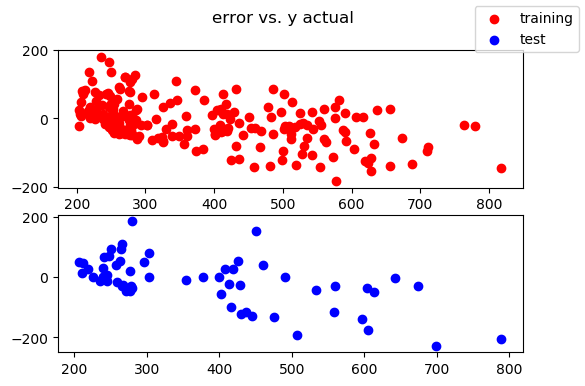

In [17]:
ModelUtils.plot_model_error(X_train,X_test,y_train.reshape(1,-1), y_test.reshape(1,-1),model)

In [18]:
from sklearn import metrics

###  R square training vs. R square testing

In [19]:
metrics.r2_score(y_train, model.predict(X_train))

0.809458143494139

In [20]:
metrics.r2_score(y_test, model.predict(X_test))

0.6748330841117443

a little overfitting 

###  mean absolute error

In [21]:
metrics.mean_absolute_error(y_train, model.predict(X_train))

48.19164860692518

In [22]:
metrics.mean_absolute_error(y_test, model.predict(X_test))

60.55918392892611

### plot history

C:\Users\Yang\.conda\envs\test_speedcom\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


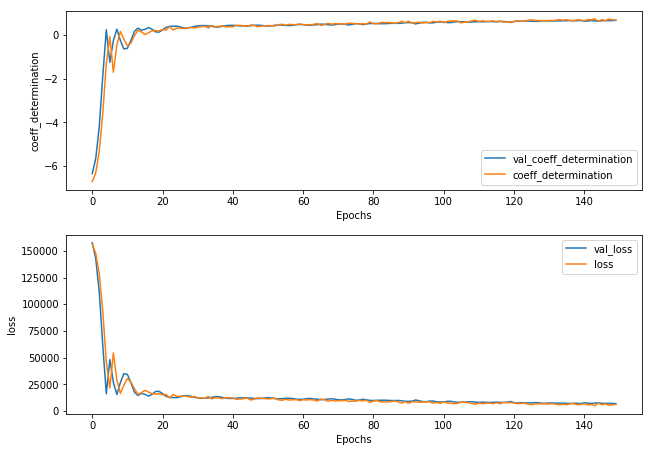

In [23]:
hist = history.history

plt.figure(figsize=(10, 8))

for label in ['val_coeff_determination','coeff_determination']:
    plt.subplot(211)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("coeff_determination")
    
for label in ['val_loss','loss']:
    plt.subplot(212)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.10, right=0.9, hspace=0.25,
                    wspace=0.35)

Add another 150 epochs

In [24]:
history1 = model.fit(x=X_train, y=y_train, batch_size=128, epochs=150, validation_data=(X_test,y_test))

Train on 232 samples, validate on 59 samples
Epoch 1/150
232/232 [==============================] - 3s 13ms/step - loss: 5637.9221 - coeff_determination: 0.7174 - lr: 2.5000e-04 - val_loss: 6716.4185 - val_coeff_determination: 0.6875 - val_lr: 2.5000e-04
Epoch 2/150
232/232 [==============================] - 4s 16ms/step - loss: 6135.3867 - coeff_determination: 0.6912 - lr: 2.5000e-04 - val_loss: 7136.6924 - val_coeff_determination: 0.6679 - val_lr: 2.5000e-04
Epoch 3/150
232/232 [==============================] - 3s 13ms/step - loss: 6099.8864 - coeff_determination: 0.6989 - lr: 2.5000e-04 - val_loss: 8235.2383 - val_coeff_determination: 0.6168 - val_lr: 2.5000e-04
Epoch 4/150
232/232 [==============================] - 3s 13ms/step - loss: 6326.9438 - coeff_determination: 0.6886 - lr: 2.5000e-04 - val_loss: 7236.1938 - val_coeff_determination: 0.6633 - val_lr: 2.5000e-04
Epoch 5/150
232/232 [==============================] - 3s 13ms/step - loss: 6386.2573 - coeff_determination: 0.6867

Epoch 40/150
232/232 [==============================] - 4s 16ms/step - loss: 5037.5328 - coeff_determination: 0.7466 - lr: 2.5000e-04 - val_loss: 7448.2764 - val_coeff_determination: 0.6534 - val_lr: 2.5000e-04
Epoch 41/150
232/232 [==============================] - 4s 16ms/step - loss: 5127.5810 - coeff_determination: 0.7400 - lr: 2.5000e-04 - val_loss: 6632.5894 - val_coeff_determination: 0.6914 - val_lr: 2.5000e-04
Epoch 42/150
232/232 [==============================] - 3s 15ms/step - loss: 4519.5781 - coeff_determination: 0.7769 - lr: 2.5000e-04 - val_loss: 6434.7515 - val_coeff_determination: 0.7006 - val_lr: 2.5000e-04
Epoch 43/150
232/232 [==============================] - 3s 15ms/step - loss: 4404.0638 - coeff_determination: 0.7818 - lr: 2.5000e-04 - val_loss: 7420.3047 - val_coeff_determination: 0.6547 - val_lr: 2.5000e-04
Epoch 44/150
232/232 [==============================] - 3s 15ms/step - loss: 4743.6646 - coeff_determination: 0.7668 - lr: 2.5000e-04 - val_loss: 8378.5049 

Epoch 79/150
232/232 [==============================] - 3s 14ms/step - loss: 4156.9107 - coeff_determination: 0.7960 - lr: 2.5000e-04 - val_loss: 6521.7109 - val_coeff_determination: 0.6965 - val_lr: 2.5000e-04
Epoch 80/150
232/232 [==============================] - 3s 14ms/step - loss: 5134.5722 - coeff_determination: 0.7470 - lr: 2.5000e-04 - val_loss: 7361.1826 - val_coeff_determination: 0.6575 - val_lr: 2.5000e-04
Epoch 81/150
232/232 [==============================] - 3s 14ms/step - loss: 3583.7531 - coeff_determination: 0.8236 - lr: 2.5000e-04 - val_loss: 9941.3506 - val_coeff_determination: 0.5374 - val_lr: 2.5000e-04
Epoch 82/150
232/232 [==============================] - 3s 14ms/step - loss: 5159.8212 - coeff_determination: 0.7474 - lr: 2.5000e-04 - val_loss: 7216.6831 - val_coeff_determination: 0.6642 - val_lr: 2.5000e-04
Epoch 83/150
232/232 [==============================] - 3s 14ms/step - loss: 3974.1285 - coeff_determination: 0.8052 - lr: 2.5000e-04 - val_loss: 6800.2988 

Epoch 118/150
232/232 [==============================] - 3s 15ms/step - loss: 3275.5640 - coeff_determination: 0.8390 - lr: 2.5000e-04 - val_loss: 9269.4102 - val_coeff_determination: 0.5687 - val_lr: 2.5000e-04
Epoch 119/150
232/232 [==============================] - 3s 15ms/step - loss: 3195.3240 - coeff_determination: 0.8434 - lr: 2.5000e-04 - val_loss: 8655.2393 - val_coeff_determination: 0.5973 - val_lr: 2.5000e-04
Epoch 120/150
232/232 [==============================] - 3s 14ms/step - loss: 3242.6623 - coeff_determination: 0.8395 - lr: 2.5000e-04 - val_loss: 8057.4175 - val_coeff_determination: 0.6251 - val_lr: 2.5000e-04
Epoch 121/150
232/232 [==============================] - 4s 16ms/step - loss: 2620.4649 - coeff_determination: 0.8707 - lr: 2.5000e-04 - val_loss: 7844.7480 - val_coeff_determination: 0.6350 - val_lr: 2.5000e-04
Epoch 122/150
232/232 [==============================] - 3s 15ms/step - loss: 2976.2783 - coeff_determination: 0.8511 - lr: 2.5000e-04 - val_loss: 9169.

In [16]:
metrics.r2_score(y_train, model.predict(X_train))

0.8098747520462612

In [17]:
metrics.r2_score(y_test, model.predict(X_test))

0.6699959726003211

In [27]:
metrics.mean_absolute_error(y_train, model.predict(X_train))

20.366384172110724

In [28]:
metrics.mean_absolute_error(y_test, model.predict(X_test))

63.42917102878376

Overfitting

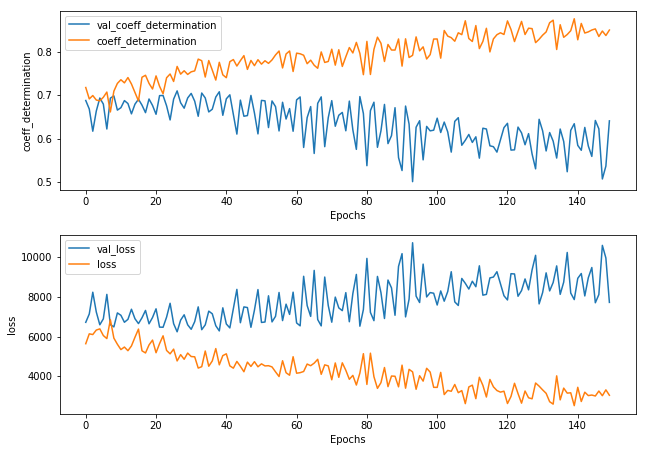

In [30]:
hist = history1.history

plt.figure(figsize=(10, 8))

for label in ['val_coeff_determination','coeff_determination']:
    plt.subplot(211)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("coeff_determination")
    
for label in ['val_loss','loss']:
    plt.subplot(212)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.10, right=0.9, hspace=0.25,
                    wspace=0.35)

## BETTER MODEL, with callback checkpointing to save the best weight

In [21]:
model = Sequential()
model.add(Embedding(len(word_map), 50, input_length=279))
model.add(BatchNormalization())
model.add(Conv1D(192,10,activation='relu'))
model.add(Dropout(0.4))
model.add(Conv1D(192,5,activation='relu'))
model.add(Conv1D(192,3,activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 279, 50)           2100      
_________________________________________________________________
batch_normalization_2 (Batch (None, 279, 50)           200       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 270, 192)          96192     
_________________________________________________________________
dropout_3 (Dropout)          (None, 270, 192)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 266, 192)          184512    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 264, 192)          110784    
_________________________________________________________________
flatten_2 (Flatten)          (None, 50688)             0         
__________

In [22]:
optimizer = Adam(lr=0.00025)
lr_metric = get_lr_metric(optimizer)
model.compile(loss="mse", optimizer=optimizer, metrics=[coeff_determination, lr_metric])

In [12]:
callbacks_list = [
    ModelCheckpoint(filepath="weights.best.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')    
]

In [23]:
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=250, validation_data=(X_test,y_test), callbacks=callbacks_list)

Train on 232 samples, validate on 59 samples
Epoch 1/250
232/232 [==============================] - 4s 18ms/step - loss: 156894.2047 - coeff_determination: -6.7024 - lr: 2.5000e-04 - val_loss: 158994.2031 - val_coeff_determination: -6.3980 - val_lr: 2.5000e-04

Epoch 00001: val_loss did not improve from 6648.25146
Epoch 2/250
232/232 [==============================] - 3s 13ms/step - loss: 150143.0690 - coeff_determination: -6.3832 - lr: 2.5000e-04 - val_loss: 147211.3281 - val_coeff_determination: -5.8497 - val_lr: 2.5000e-04

Epoch 00002: val_loss did not improve from 6648.25146
Epoch 3/250
232/232 [==============================] - 3s 13ms/step - loss: 135343.5471 - coeff_determination: -5.6983 - lr: 2.5000e-04 - val_loss: 122468.0703 - val_coeff_determination: -4.6984 - val_lr: 2.5000e-04

Epoch 00003: val_loss did not improve from 6648.25146
Epoch 4/250
232/232 [==============================] - 3s 13ms/step - loss: 106390.6212 - coeff_determination: -4.3284 - lr: 2.5000e-04 - val_


Epoch 00061: val_loss did not improve from 6648.25146
Epoch 62/250
232/232 [==============================] - 4s 15ms/step - loss: 10393.8415 - coeff_determination: 0.4890 - lr: 2.5000e-04 - val_loss: 11212.8838 - val_coeff_determination: 0.4783 - val_lr: 2.5000e-04

Epoch 00062: val_loss did not improve from 6648.25146
Epoch 63/250
232/232 [==============================] - 3s 14ms/step - loss: 10158.7515 - coeff_determination: 0.5039 - lr: 2.5000e-04 - val_loss: 12039.1250 - val_coeff_determination: 0.4398 - val_lr: 2.5000e-04

Epoch 00063: val_loss did not improve from 6648.25146
Epoch 64/250
232/232 [==============================] - 3s 14ms/step - loss: 10279.9936 - coeff_determination: 0.4944 - lr: 2.5000e-04 - val_loss: 12248.5410 - val_coeff_determination: 0.4301 - val_lr: 2.5000e-04

Epoch 00064: val_loss did not improve from 6648.25146
Epoch 65/250
232/232 [==============================] - 3s 15ms/step - loss: 10986.8107 - coeff_determination: 0.4582 - lr: 2.5000e-04 - val_


Epoch 00122: val_loss did not improve from 6648.25146
Epoch 123/250
232/232 [==============================] - 3s 15ms/step - loss: 8873.4993 - coeff_determination: 0.5592 - lr: 2.5000e-04 - val_loss: 8731.7910 - val_coeff_determination: 0.5937 - val_lr: 2.5000e-04

Epoch 00123: val_loss did not improve from 6648.25146
Epoch 124/250
232/232 [==============================] - 4s 15ms/step - loss: 8314.8986 - coeff_determination: 0.5931 - lr: 2.5000e-04 - val_loss: 8439.4033 - val_coeff_determination: 0.6073 - val_lr: 2.5000e-04

Epoch 00124: val_loss did not improve from 6648.25146
Epoch 125/250
232/232 [==============================] - 3s 15ms/step - loss: 8163.4407 - coeff_determination: 0.5997 - lr: 2.5000e-04 - val_loss: 7481.6743 - val_coeff_determination: 0.6519 - val_lr: 2.5000e-04

Epoch 00125: val_loss did not improve from 6648.25146
Epoch 126/250
232/232 [==============================] - 3s 14ms/step - loss: 7933.2635 - coeff_determination: 0.5931 - lr: 2.5000e-04 - val_los


Epoch 00182: val_loss improved from 6271.60693 to 6240.91211, saving model to weights.best.hdf5
Epoch 183/250
232/232 [==============================] - 3s 15ms/step - loss: 5381.1478 - coeff_determination: 0.7343 - lr: 2.5000e-04 - val_loss: 6488.3623 - val_coeff_determination: 0.6981 - val_lr: 2.5000e-04

Epoch 00183: val_loss did not improve from 6240.91211
Epoch 184/250
232/232 [==============================] - 3s 14ms/step - loss: 5046.3825 - coeff_determination: 0.7524 - lr: 2.5000e-04 - val_loss: 8393.5703 - val_coeff_determination: 0.6094 - val_lr: 2.5000e-04

Epoch 00184: val_loss did not improve from 6240.91211
Epoch 185/250
232/232 [==============================] - 3s 14ms/step - loss: 7310.4795 - coeff_determination: 0.6373 - lr: 2.5000e-04 - val_loss: 6342.2871 - val_coeff_determination: 0.7049 - val_lr: 2.5000e-04

Epoch 00185: val_loss did not improve from 6240.91211
Epoch 186/250
232/232 [==============================] - 3s 14ms/step - loss: 5965.2848 - coeff_determ

232/232 [==============================] - 3s 15ms/step - loss: 5106.4431 - coeff_determination: 0.7392 - lr: 2.5000e-04 - val_loss: 6443.9526 - val_coeff_determination: 0.7002 - val_lr: 2.5000e-04

Epoch 00213: val_loss did not improve from 6040.80176
Epoch 214/250
232/232 [==============================] - 3s 15ms/step - loss: 4583.9133 - coeff_determination: 0.7739 - lr: 2.5000e-04 - val_loss: 8927.2480 - val_coeff_determination: 0.5846 - val_lr: 2.5000e-04

Epoch 00214: val_loss did not improve from 6040.80176
Epoch 215/250
232/232 [==============================] - 4s 16ms/step - loss: 5929.3675 - coeff_determination: 0.7090 - lr: 2.5000e-04 - val_loss: 6252.2754 - val_coeff_determination: 0.7091 - val_lr: 2.5000e-04

Epoch 00215: val_loss did not improve from 6040.80176
Epoch 216/250
232/232 [==============================] - 4s 15ms/step - loss: 4353.1433 - coeff_determination: 0.7835 - lr: 2.5000e-04 - val_loss: 5966.6250 - val_coeff_determination: 0.7224 - val_lr: 2.5000e-04




Epoch 00243: val_loss did not improve from 5966.62500
Epoch 244/250
232/232 [==============================] - 4s 15ms/step - loss: 3509.1955 - coeff_determination: 0.8286 - lr: 2.5000e-04 - val_loss: 7757.6851 - val_coeff_determination: 0.6390 - val_lr: 2.5000e-04

Epoch 00244: val_loss did not improve from 5966.62500
Epoch 245/250
232/232 [==============================] - 3s 14ms/step - loss: 4820.7030 - coeff_determination: 0.7573 - lr: 2.5000e-04 - val_loss: 8347.9160 - val_coeff_determination: 0.6116 - val_lr: 2.5000e-04

Epoch 00245: val_loss did not improve from 5966.62500
Epoch 246/250
232/232 [==============================] - 3s 15ms/step - loss: 4053.8826 - coeff_determination: 0.7988 - lr: 2.5000e-04 - val_loss: 7358.0449 - val_coeff_determination: 0.6576 - val_lr: 2.5000e-04

Epoch 00246: val_loss did not improve from 5966.62500
Epoch 247/250
232/232 [==============================] - 3s 14ms/step - loss: 3458.0008 - coeff_determination: 0.8300 - lr: 2.5000e-04 - val_los

In [24]:
metrics.r2_score(y_train, model.predict(X_train))

0.8974157227111998

In [18]:
metrics.r2_score(y_test, model.predict(X_test))

0.7223731940962453

In [46]:
metrics.mean_absolute_error(y_train, model.predict(X_train))

41.79162478479846

In [47]:
metrics.mean_absolute_error(y_test, model.predict(X_test))

55.02284370034428

C:\Users\Yang\.conda\envs\test_speedcom\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


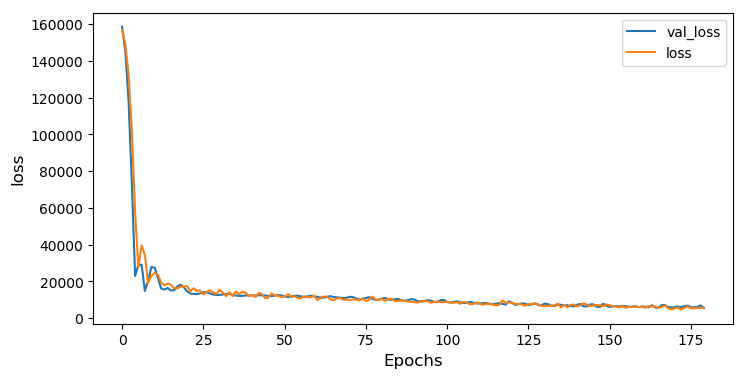

In [89]:
hist = history.history

plt.figure(figsize=(8, 10), dpi=100)


    
for label in ['val_loss','loss']:
    plt.subplot(212)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs",fontsize = 12)
    plt.ylabel("loss", fontsize = 12)
    
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.10, right=0.9, hspace=0.25,
                    wspace=0.35)

plt.savefig('loss_vs_epochs_smiles_cnn.png')

In [86]:
loss_history = history.history["loss"]
numpy_loss_history = np.array(loss_history)

In [102]:
np_R2_history = np.array(history.history['coeff_determination'])

### save the loss and R2 in the history

In [101]:
np.savetxt("loss_history_epoch_smiles_cnn.txt", numpy_loss_history, delimiter=",")

In [104]:
np.savetxt("R2_history.txt" ,np_R2_history, delimiter=",")

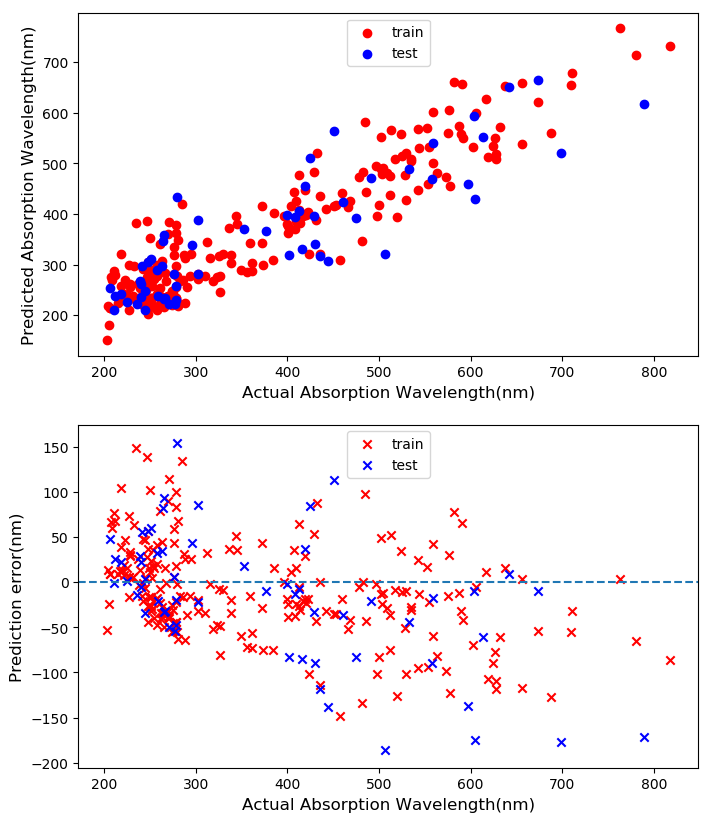

In [99]:
plt.figure(figsize=(8, 10), dpi=100)
plt.subplot(211)
plt.scatter(y_train, model.predict(X_train), color = 'r', label = 'train')
plt.scatter(y_test, model.predict(X_test), color = 'blue', label = 'test')
plt.xlabel('Actual Absorption Wavelength(nm)', fontsize=12)
plt.ylabel('Predicted Absorption Wavelength(nm)', fontsize=12)
plt.legend(loc='upper center')

plt.subplot(212)
plt.scatter(y_train, model.predict(X_train)-y_train, color = 'r', label = 'train', marker= 'x')
plt.scatter(y_test, model.predict(X_test)-y_test, color = 'blue', label = 'test', marker = 'x')
plt.axhline(0, ls='--')
plt.xlabel('Actual Absorption Wavelength(nm)', fontsize=12)
plt.ylabel('Prediction error(nm)', fontsize=12)
plt.legend(loc='upper center')

plt.savefig('smiles_cnn_metrics_plot.png')

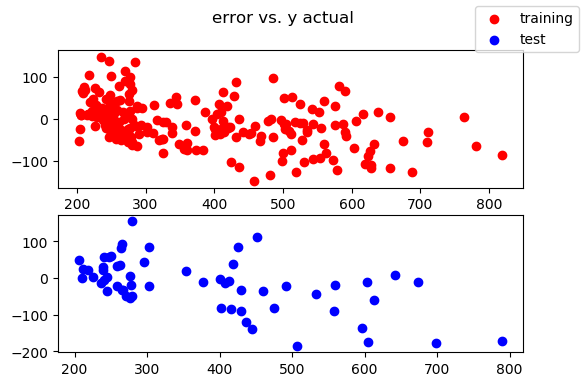

In [49]:
ModelUtils.plot_model_error(X_train,X_test,y_train.reshape(1,-1), y_test.reshape(1,-1),model)

### To SAVE model AND Weight

In [26]:
model_json = model.to_json()
with open("model_smiles_cnn.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("model_smiles_cnn.h5")
print("Saved model to disk")

Saved model to disk


### To LOAD model

In [9]:
from keras.models import model_from_json

In [10]:
json_file = open('model_smiles_cnn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
loaded_model.load_weights('weights.best.hdf5')

In [12]:
y_train

array([[544.25],
       [431.25],
       [559.5],
       [326.0],
       [227.0],
       [243.0],
       [275.0],
       [293.75],
       [228.0],
       [263.75],
       [253.0],
       [288.0],
       [220.0],
       [227.0],
       [227.0],
       [687.5],
       [225.0],
       [251.0],
       [401.0],
       [249.0],
       [404.25],
       [218.0],
       [559.25],
       [288.0],
       [280.0],
       [261.0],
       [582.0],
       [323.75],
       [265.0],
       [396.25],
       [215.0],
       [435.75],
       [217.0],
       [502.0],
       [274.25],
       [573.0],
       [356.25],
       [478.0],
       [509.0],
       [316.0],
       [519.4],
       [587.0],
       [578.0],
       [228.0],
       [459.25],
       [384.0],
       [518.0],
       [818.0],
       [251.0],
       [417.0],
       [372.0],
       [637.5],
       [603.0],
       [528.0],
       [419.25],
       [278.0],
       [656.0],
       [258.0],
       [619.0],
       [248.0],
       [627.5],
       [235

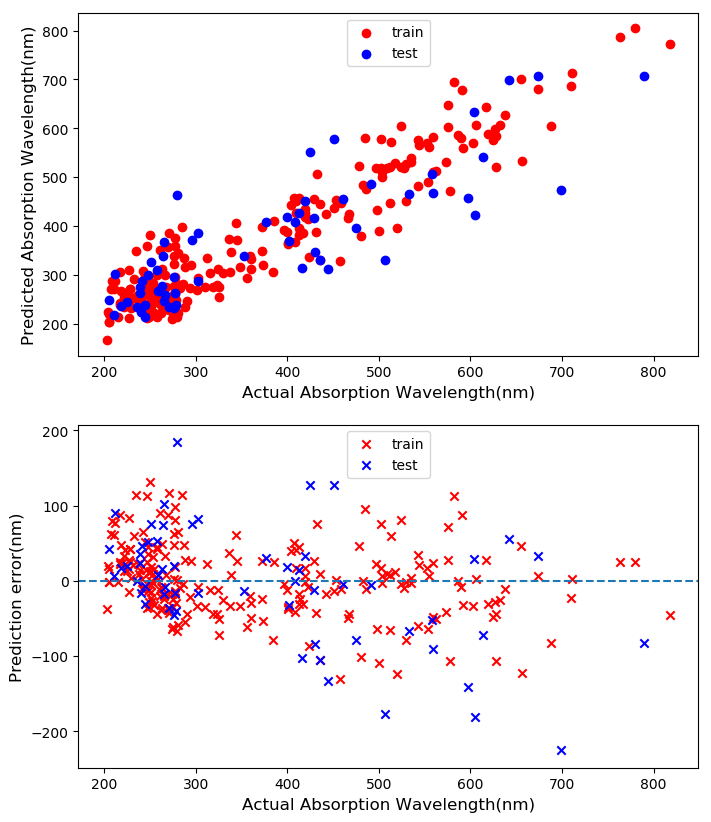

In [13]:
plt.figure(figsize=(8, 10), dpi=100)
plt.subplot(211)
plt.scatter(y_train, loaded_model.predict(X_train), color = 'r', label = 'train')
plt.scatter(y_test, loaded_model.predict(X_test), color = 'blue', label = 'test')
plt.xlabel('Actual Absorption Wavelength(nm)', fontsize=12)
plt.ylabel('Predicted Absorption Wavelength(nm)', fontsize=12)
plt.legend(loc='upper center')

plt.subplot(212)
plt.scatter(y_train, loaded_model.predict(X_train)-y_train, color = 'r', label = 'train', marker= 'x')
plt.scatter(y_test, loaded_model.predict(X_test)-y_test, color = 'blue', label = 'test', marker = 'x')
plt.axhline(0, ls='--')
plt.xlabel('Actual Absorption Wavelength(nm)', fontsize=12)
plt.ylabel('Prediction error(nm)', fontsize=12)
plt.legend(loc='upper center')

plt.savefig('smiles_cnn_metrics_plot_loaded_model.png')

In [14]:
rev_wordmap=DataUtils.reverse_wordmap(word_map)

In [15]:
DataUtils.decode_num_smiles(X_train, rev_wordmap)

array(['CCN1C2=CC=CC=C2C(C1=CC=CC3=[N+](C4=CC=CC=C4C3(C)C)CC)(C)C',
       'CN(C)C1=CC=C(C=C1)C(=N)C2=CC=C(C=C2)N(C)C.Cl',
       'CCCCN1C(=O)C(=C/C=C/C=C\\2/N(C3=CC=CC=C3O2)CCCS(=O)(=O)[O-])C(=O)N(C1=S)CCCC',
       'C1=CC=C(C=C1)C#CC#CC2=CC=CC=C2', 'B(C1=CC=CC=C1)(O)O',
       'C1=NC2=C(N1)C(=O)NC(=N2)N', 'C1=CC=C2C(=C1)C=CC(=O)O2',
       'C1=CC=C(C=C1)/C=C/C2=CC=CC=C2', 'C1=CC=C(C=C1)I',
       'CC1=CNC(=O)NC1=O', 'C1=CC2=NNN=C2C=C1', 'C1=CC=C(C=C1)N',
       'COC1=CC=CC=C1', 'CC(=O)C1=CC=CC=N1',
       'C1=CC2=C3C(=CC=C4C3=C1C(=O)OC4=O)C(=O)OC2=O',
       'CCN1C2=CC=CC=C2OC1=CC=CC=CC=CC3=[N+](C4=CC=CC=C4O3)CC',
       'CCOC(=O)C1=CC=CC=C1C(=O)OCC', 'CN(C)C1=CC=CC=C1',
       'CCC1=C2C=C3C(=C(C(=N3)C(=C4[C@H]([C@@H](C(=N4)C=C5C(=C(C(=CC(=C1C)N2)N5)C=C)C)C)CCC(=O)O)CC(=O)O)C(=O)O)C',
       'C1=CC=C2C(=C1)C=CC(=O)C2=O',
       'CCC1=C(C2=CC3=NC(=CC4=C(C(=C([N-]4)C=C5C(=C(C(=N5)C=C1[N-]2)CC)CC)CC)CC)C(=C3CC)CC)CC.[Zn+2]',
       'C1=CC=C(C=C1)NC2=CC=CC3=C2C(=CC=C3)S(=O)(=O)O',
      

In [16]:
metrics.r2_score(y_train, loaded_model.predict(X_train))

0.8895332829013725

In [17]:
metrics.r2_score(y_test, loaded_model.predict(X_test))

0.7223731940962453

In [18]:
indivisual_X_string1=X[9]
indivisual_X_string2=X[12]

In [19]:
indivisual_X_code = DataUtils.numeric_encoding(np.array([indivisual_X_string1, indivisual_X_string2]), uniform_length,word_map)

In [20]:
indivisual_X_code.shape

(2, 279)

In [21]:
X_train.shape

(232, 279)

In [23]:
loaded_wordmap=DataUtils.load_wordmap_from_json('smiles_wordmap.json')

In [22]:
loaded_model.predict(indivisual_X_code)

array([[234.532  ],
       [231.50722]], dtype=float32)

In [27]:
def predict_abs_wavelength(smiles_string = 'C1=CC=CC=C1', uniform_length_of_model = 279, word_map = None, model = None):
    indivisual_X_code = DataUtils.numeric_encoding(np.array([smiles_string]), uniform_length_of_model,word_map)
    pred_abs_wl = model.predict(indivisual_X_code)
    return pred_abs_wl

In [28]:
predict_abs_wavelength(smiles_string='CC(=O)C1=C(C(=C(C=C1)O)O)O', word_map=loaded_wordmap, model=loaded_model)

array([[246.85786]], dtype=float32)